In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [1]:
!pip install cvxpy

In [2]:
import numpy as np
import cvxpy as cp

def dspca_upper_bound(orig_matrix, k):
    p = orig_matrix.shape[0]
    X = cp.Variable((p, p), symmetric=True)
    objective = cp.Maximize(cp.trace(orig_matrix @ X))
    constraints = [
        cp.trace(X) == 1,
        X >> 0,
        cp.norm1(X) <= k  # L1 sparsity relaxation
    ]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    return problem.value

In [5]:
def generate_normalized_covariance(K, p, seed=42):
    np.random.seed(seed)
    D = np.random.randn(K, p)
    D /= np.linalg.norm(D, axis=1, ord=2, keepdims=True)
    B = D @ D.T
    B /= np.linalg.norm(B, ord=2)
    return B

In [6]:
results = []
K = 30
p = 10
B = generate_normalized_covariance(K, p)

for k in tqdm(range(1, K+1), desc="Computing DSPCA bounds"):
    val = dspca_upper_bound(B, k)
    if k > 1:
        val = max(val, results[-1])  # enforce monotonicity
    results.append(val)

Computing DSPCA bounds:   0%|          | 0/30 [00:00<?, ?it/s]

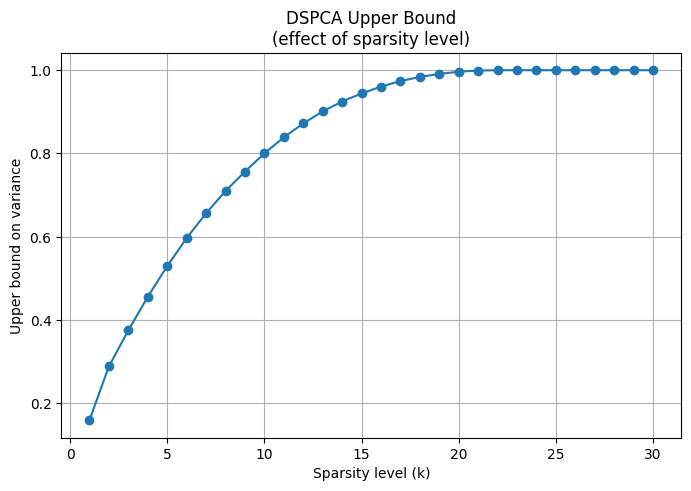

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, K+1), results, marker='o')
plt.title("DSPCA Upper Bound\n(effect of sparsity level)")
plt.xlabel("Sparsity level (k)")
plt.ylabel("Upper bound on variance")
plt.grid(True)
plt.savefig("dspca_upper_bound.png", dpi=300)
plt.show()

In [8]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def experiment_varying_dimensions_dspca():
    K = 30
    n_dims_list = [2, 5, 10, 20]
    results = {}

    for p in tqdm(n_dims_list):
        D = np.random.randn(K, p)
        D /= np.linalg.norm(D, axis=1, ord=2, keepdims=True)
        B = D @ D.T
        L = np.linalg.norm(B, ord=2)
        B /= L

        results[p] = []
        for k in range(1, K + 1):
            val = dspca_upper_bound(B, k)
            if k > 1:
                val = max(val, results[p][-1])
            results[p].append(val)

    return results

results_dspca_dims = experiment_varying_dimensions_dspca()

100%|██████████| 4/4 [01:07<00:00, 16.77s/it]


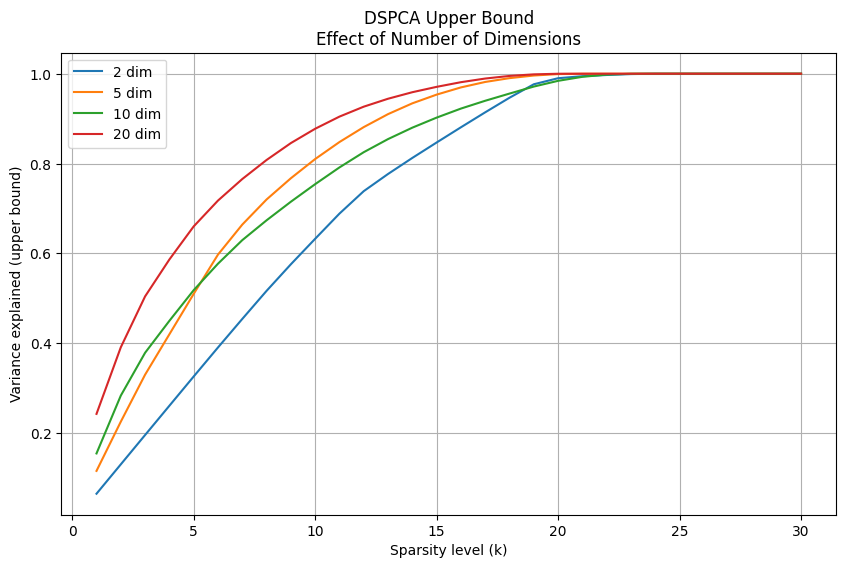

In [9]:
plt.figure(figsize=(10,6))
plt.title("DSPCA Upper Bound\nEffect of Number of Dimensions")
for dim, values in results_dspca_dims.items():
    plt.plot(range(1, 31), values, label=f"{dim} dim")
plt.xlabel("Sparsity level (k)")
plt.ylabel("Variance explained (upper bound)")
plt.legend()
plt.grid(True)
plt.savefig("number_of_dims_dspca.png")
plt.show()